<a href="https://colab.research.google.com/github/solharsh/Company_Project_Food_Safety/blob/master/Food_Safery_Amazon_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install xgboost

In [3]:
!pip install catboost

     |████████████████████████████████| 64.8MB 108kB/s 


In [4]:
!pip install lightgbm

In [5]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
import xgboost as xgb	
import lightgbm as lgb	
import catboost	
import pandas as pd	
import numpy as np	
from sklearn.model_selection import train_test_split	
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')	
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
stop_words = set(stopwords.words('english'))
stop_words.remove('off')	
stop_words.add('amazon')	
stop_words.add('product')	
stop_words.add('info')

In [0]:
lmtzr = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')

# Prepare training data

In [0]:
df = pd.read_csv('/content/drive/My Drive/Food_Safety_Amazon/training.csv', sep=None, header=0, index_col=False, parse_dates=['Timestamp'],engine='python')

In [7]:
df.head(5)

,ID,Product ASIN,Review star rating,Food Safety Issue,Review Text,Review Title,@nlp.sentenceCount,@product.brand,@product.countryOfOrigin,Product Width,Product Length,Product Height,Timestamp,Product Title (Analyzed)
0,2024,B004DSMGXE,1,1,Very stale! Went into garbage....,Went into garbage..,3,Ferrara,MX,NaN,NaN,NaN,2017-10-29 09:43:00,"Wrapped Vanilla Caramel Squares 2lb, 2 Pound"
1,4208,B003XDM33I,1,1,I always use raw cashews in my smoothies and a...,... raw cashews in my smoothies and as these t...,2,Sunfood,NaN,2.9,7.8,2.6,2017-12-20 00:18:00,"Sunfood Cashews, Whole, 1lb, Organic, Raw"
2,3373,B01H4B1DB2,1,1,I am super pissed off. I can�t return this? Pr...,I am super pissed off,6,Forever Green,NaN,NaN,NaN,NaN,2018-01-15 03:21:00,Paradise Green Uncrystallized Dried Ginger Sli...
3,3388,B00JJY30R8,1,1,These are so hard and stale you can break a to...,Inedible Marpo Marshmallow Candy Cones,2,Marpro,NaN,NaN,NaN,NaN,2018-03-28 01:09:00,Marpro Yum Yum Marshmallow Candy Cones - 30 Ct...
4,5004,B003RLNOYS,1,1,"I love larabars. What I don�t love, and what e...","Moldy, smelly, disgusting in the last 2 orders",5,L�RABAR,US,4.0,2.0,6.0,2017-11-30 18:40:00,"Larabar Gluten Free Bar, Chocolate Chip Cookie..."


In [8]:
df.columns

Index(['ID', 'Product ASIN', 'Review star rating', 'Food Safety Issue',
       'Review Text', 'Review Title', '@nlp.sentenceCount', '@product.brand',
       '@product.countryOfOrigin', 'Product Width', 'Product Length',
       'Product Height', 'Timestamp', 'Product Title (Analyzed)'],
      dtype='object')

In [9]:
df.describe()

,ID,Review star rating,Food Safety Issue,@nlp.sentenceCount,Product Width,Product Length,Product Height
count,3769.000000,3769.000000,3769.000000,3769.000000,1469.000000,1469.000000,1469.000000
mean,2691.956487,1.472008,0.864155,4.715309,4.973349,6.718455,5.675956
std,1554.811470,0.778782,0.342669,4.082598,3.001311,4.314668,3.741902
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1340.000000,1.000000,1.000000,2.000000,2.900000,3.500000,3.000000
50%,2716.000000,1.000000,1.000000,4.000000,4.500000,6.000000,5.500000
75%,4024.000000,2.000000,1.000000,6.000000,6.500000,9.000000,7.870000
max,5384.000000,5.000000,1.000000,104.000000,32.000000,84.000000,84.000000


In [10]:
df.isnull().sum(axis=0)

ID                             0
Product ASIN                   0
Review star rating             0
Food Safety Issue              0
Review Text                    0
Review Title                   0
@nlp.sentenceCount             0
@product.brand                79
@product.countryOfOrigin    2801
Product Width               2300
Product Length              2300
Product Height              2300
Timestamp                      0
Product Title (Analyzed)       0
dtype: int64

In [11]:
df['Food Safety Issue'].value_counts()

1    3257
0     512
Name: Food Safety Issue, dtype: int64

# Define feature engineering functions

In [0]:
def preprocess(s):
    if isinstance(s, str):
        s = re.sub(r'[^a-zA-Z\s]', '', s, re.I|re.A)
        s = str(s).lower()
        word_list = tokenizer.tokenize(s)
        word_list = [word for word in word_list if not word in stop_words]
        word_list = [lmtzr.lemmatize(word) for word in word_list]
        return word_list
    return []
	
def word_vector(s):
	  word_list = preprocess(s)
	  return np.mean([words[x].values for x in word_list if x in words],axis=0)
	
	
def get_sentiment_scores_of_sentence(sentence):
  word_list = preprocess(sentence)
  sentimentAnalyser = SentimentIntensityAnalyzer()
  sentimentScores = sentimentAnalyser.polarity_scores(' '.join(word_list))
  return sentimentScores
	
def get_sentiment_scores_of_column(df, columnName):	
    sentimentScoresHeader = [columnName+'_neg', columnName+'_neu', columnName+'_pos', columnName+'_compound']
    sentimentScoresDf = pd.DataFrame(np.nan, index=[], columns=sentimentScoresHeader)
    isOverallNeg = []
    for i in range(df.shape[0]): #range(10, 21):
        sentence = df.loc[i, columnName]
        if isinstance(sentence, str):
            curScores = get_sentiment_scores_of_sentence(sentence)
            curScoresDf = pd.DataFrame.from_dict(dict([ [sentimentScoresHeader[0], [curScores.get('neg')]],
                                                        [sentimentScoresHeader[1], [curScores.get('neu')]],
                                                        [sentimentScoresHeader[2], [curScores.get('pos')]],
                                                        [sentimentScoresHeader[3], [curScores.get('compound')]] ]), orient='columns')
        else:
            curScoresDf = pd.DataFrame.from_dict(dict([ [sentimentScoresHeader[0], [0.0]],
                                                        [sentimentScoresHeader[1], [0.0]],
                                                        [sentimentScoresHeader[2], [0.0]],
                                                        [sentimentScoresHeader[3], [0.0]] ]), orient='columns')
        sentimentScoresDf = sentimentScoresDf.append(curScoresDf, ignore_index=True)
	
        if (curScores.get('neg') > curScores.get('pos')):
            isOverallNeg.append(1)
        else:
            isOverallNeg.append(0)
    return sentimentScoresDf, isOverallNeg

# Add sentiment score

In [0]:
TextSentimentScores, TextIsOverallNeg = get_sentiment_scores_of_column(df, 'Review Text')
TitleSentimentScores, TitleIsOverallNeg = get_sentiment_scores_of_column(df, 'Review Title')

# Add missing value indicator

In [0]:
df['missingorigin'] = df['@product.countryOfOrigin'].apply(lambda x: 1 if pd.isnull(x) else 0)
df['Product Width'].fillna(-1, inplace=True)
df['Product Height'].fillna(-1, inplace=True)
df['Product Length'].fillna(-1, inplace=True)
df['missingwd'] = df.apply(lambda x: 1 if x['Product Width']+x['Product Length']+x['Product Height']==-1 else 0, axis=1)

# Add other features

In [0]:
df['timezero'] = pd.Timestamp('20170101')
df['timedif'] = (df['Timestamp'] - df['timezero']).apply(lambda x: x.days)
#df['timedif'].head(5)
df['volumn'] = df['Product Width'] * df['Product Length'] * df['Product Height']

# add review text word2vec


In [47]:
#!git clone https://github.com/mmihaltz/word2vec-GoogleNews-vectors.git

fatal: destination path 'word2vec-GoogleNews-vectors' already exists and is not an empty directory.


In [32]:
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')
#vec_king = wv['king']

[=================================================-] 98.5% 1637.2/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
words = pd.read_table("https://www.dropbox.com/s/flh1fjynqvdsj4p/lexvec.commoncrawl.300d.W.pos.vectors.gz?dl=1", compression="gzip", encoding="utf-8", sep=" ", index_col=0, header=None, skiprows=[0]).transpose()
#words = pd.read_table("/content/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz", compression="gzip", encoding="utf-8", sep=" ", index_col=0, header=None, skiprows=[0]).transpose()

In [0]:
df['text2vec'] = df['Review Text'].apply(word_vector)

In [19]:
reviewarray = np.zeros((len(df), 300))
for i in range(len(df)):
    reviewarray[i, :] = df['text2vec'][i]
reviewarray.shape

(3769, 300)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage	
similarity_matrix = cosine_similarity(reviewarray)
Z = linkage(similarity_matrix, 'ward')

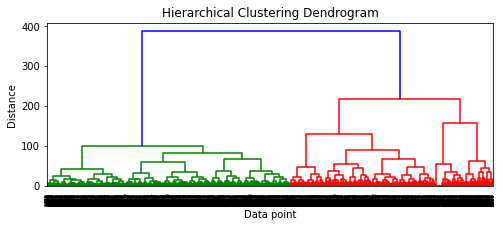

In [21]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [22]:
from scipy.cluster.hierarchy import fcluster
max_dist = 250.
cluster_labels = fcluster(Z, max_dist, criterion='distance')
w2vlabels = pd.DataFrame(cluster_labels, columns=['clusterlabelw2v'])
catdf = pd.concat([df, w2vlabels ], axis=1)
print(len(catdf[(catdf['Food Safety Issue']==0) & (catdf.clusterlabelw2v==1)]))
print(len(catdf[(catdf['Food Safety Issue']==0) & (catdf.clusterlabelw2v==2)]))
print(len(catdf[(catdf['Food Safety Issue']==1) & (catdf.clusterlabelw2v==1)]))
print(len(catdf[(catdf['Food Safety Issue']==1) & (catdf.clusterlabelw2v==2)]))

335
177
1715
1542


In [0]:
text_split = df['text2vec'].apply(lambda x: pd.Series([x[i] for i in range(300)]))

In [0]:
text_split.rename(columns={i:'text' + str(i+1) for i in range(300)},inplace=True)

In [0]:
df1 = pd.concat([df, w2vlabels, text_split], axis=1)

# add review title word2vec

In [26]:
df1['title2vec'] = df1['Review Title'].apply(word_vector)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [0]:
title_split = df1['title2vec'].apply(lambda x: pd.Series([x[i] if not isinstance(x,np.float64) else np.nan for i in range(300)]))

In [0]:
title_split.rename(columns={i:'title' + str(i+1) for i in range(300)},inplace=True)

In [0]:
df2 = pd.concat([df1, title_split], axis=1)

In [30]:
df['timedif'].groupby(df['Food Safety Issue']).median()

Food Safety Issue
0    326
1    330
Name: timedif, dtype: int64

In [31]:
df['volumn'].groupby(df['Food Safety Issue']).median()

Food Safety Issue
0   -1.0
1   -1.0
Name: volumn, dtype: float64

# add bag-of-words


In [0]:
def clean(s):
    s = re.sub(r'[^a-zA-Z\s]', '', s, re.I|re.A)
    s = str(s).lower()
    word_list = tokenizer.tokenize(s)
    word_list = [word for word in word_list if not word in stop_words]
    word_list = [lmtzr.lemmatize(word) for word in word_list]
    return ' '.join(word_list)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df2['Review Text'].apply(clean))
cv_matrix = cv_matrix.toarray()
cv_matrix.shape

(3769, 8653)

In [0]:
vocab = cv.get_feature_names()
bow = pd.DataFrame(cv_matrix, columns=vocab)

# add n-gram

In [0]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(df2['Review Text'].apply(clean))
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
bigram = pd.DataFrame(bv_matrix, columns=vocab)

# add tf-idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df2['Review Text'].apply(clean))
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
tfidf = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

#tf-idf cluster

In [37]:
similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3729,3730,3731,3732,3733,3734,3735,3736,3737,3738,3739,3740,3741,3742,3743,3744,3745,3746,3747,3748,3749,3750,3751,3752,3753,3754,3755,3756,3757,3758,3759,3760,3761,3762,3763,3764,3765,3766,3767,3768
0,1.000000,0.000000,0.000000,0.025378,0.000000,0.000000,0.000000,0.000000,0.000000,0.080748,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.036895,0.075386,0.000000,0.021700,0.000000,0.000000,0.0,0.000000,0.034085,0.000000,0.000000,0.000000,0.028618,0.020092,0.000000,0.030672,0.033027,0.000000,0.000000,0.024360,0.023824,0.036154,0.000000,0.133837,...,0.086361,0.036521,0.000000,0.038339,0.000000,0.0,0.044494,0.000000,0.000000,0.000000,0.000000,0.000000,0.013606,0.000000,0.034680,0.000000,0.029323,0.000000,0.000000,0.000000,0.000000,0.089879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.271559,0.027907,0.027925,0.000000,0.066535,0.000000,0.046378,0.000000,0.000000,0.000000,0.016310
1,0.000000,1.000000,0.000000,0.025238,0.000000,0.000000,0.046995,0.013822,0.000000,0.000000,0.030268,0.014723,0.056258,0.000000,0.0,0.000000,0.000000,0.000000,0.017298,0.000000,0.000000,0.035697,0.0,0.029488,0.000000,0.019234,0.000000,0.041220,0.066877,0.009469,0.012225,0.065225,0.000000,0.000000,0.000000,0.021954,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032914,0.015177,0.000000,0.000000,0.0,0.055279,0.016215,0.063918,0.000000,0.012674,0.024753,0.010514,0.000000,0.051507,0.052469,0.000000,0.000000,0.000000,0.013992,0.058869,0.000000,0.000000,0.022663,0.087273,0.014740,0.053614,0.000000,0.0,0.000000,0.000000,0.013160,0.036163,0.000000,0.000000,0.000000,0.042744,0.000000,0.024345,0.056884
2,0.000000,0.000000,1.000000,0.114552,0.000000,0.000000,0.000000,0.032535,0.000000,0.000000,0.000000,0.024404,0.045650,0.032163,0.0,0.000000,0.000000,0.000000,0.018686,0.022094,0.038428,0.037889,0.0,0.010214,0.044447,0.000000,0.000000,0.000000,0.000000,0.000000,0.015233,0.034026,0.000000,0.039574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.078712,0.0,0.000000,0.017876,0.000000,0.000000,0.000000,0.173475,0.017743,0.000000,0.044706,0.000000,0.038237,0.000000,0.045711,0.000000,0.000000,0.000000,0.042237,0.026988,0.000000,0.040113,0.000000,0.000000,0.0,0.000000,0.067350,0.000000,0.068122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.025378,0.025238,0.114552,1.000000,0.000000,0.000000,0.000000,0.031776,0.000000,0.027788,0.057636,0.044986,0.011375,0.000000,0.0,0.000000,0.012697,0.025943,0.000000,0.007468,0.000000,0.017010,0.0,0.000000,0.011730,0.000000,0.000000,0.000000,0.009849,0.006914,0.000000,0.043787,0.011366,0.038650,0.000000,0.008383,0.008199,0.055790,0.000000,0.046059,...,0.029720,0.056355,0.000000,0.013194,0.000000,0.0,0.015312,0.017459,0.000000,0.000000,0.000000,0.026651,0.004682,0.000000,0.011935,0.000000,0.010091,0.000000,0.000000,0.000000,0.000000,0.030931,0.041251,0.000000,0.000000,0.056284,0.036715,0.000000,0.0,0.093454,0.039840,0.009610,0.030583,0.022897,0.000000,0.071567,0.000000,0.000000,0.000000,0.005613
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.156748,0.000000,0.000000,0.034516,0.050764,0.000000,0.010538,0.112708,0.015507,0.0,0.000000,0.074308,0.000000,0.140053,0.027943,0.025875,0.126389,0.0,0.058458,0.026087,0.018882,0.011934,0.014783,0.000000,0.000000,0.016962,0.040310,0.000000,0.056524,0.029596,0.050096,0.010958,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.013445,0.000000,0.040599,0.0,0.119648,0.010130,0.018710,0.042519,0.008931,0.000000,0.045455,0.009166,0.027102,0.000000,0.000000,0.114169,0.019236,0.027221,0.042531,0.000000,0.072962,0.008171,0.000000,0.045699,0.000000,0.017417,0.0,0.000000,0.021359,0.022291,0.017926,0.000000,0.000000,0.000000,0.052962,0.051536,0.000000,0.018612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [38]:
Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns=['Document\Cluster 1', 'Document\Cluster 2', 'Distance', 'Cluster Size'], dtype='object')

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,810,2091,0,2
1,490,2584,0,2
2,68,2496,0,2
3,2344,2564,0,2
4,39,1162,0,2
...,...,...,...,...
3763,7527,7531,23.1005,2450
3764,7498,7532,30.0156,2586
3765,7524,7530,47.6067,1130
3766,7533,7534,70.6721,3716


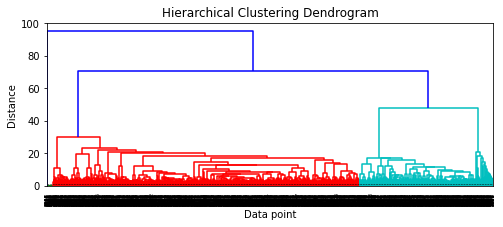

In [39]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [0]:
max_dist = 80.
cluster_labels = fcluster(Z, max_dist, criterion='distance')
tfidflabels = pd.DataFrame(cluster_labels, columns=['clusterlabeltfidf'])
#pd.concat([corpus_df, cluster_labels], axis=1)

In [42]:
catdf = pd.concat([df, tfidflabels], axis=1)
print(len(catdf[(catdf['Food Safety Issue']==0) & (catdf.clusterlabeltfidf==1)]))
print(len(catdf[(catdf['Food Safety Issue']==0) & (catdf.clusterlabeltfidf==2)]))
print(len(catdf[(catdf['Food Safety Issue']==1) & (catdf.clusterlabeltfidf==1)]))
print(len(catdf[(catdf['Food Safety Issue']==1) & (catdf.clusterlabeltfidf==2)]))

2
510
51
3206


#add LDA (too slow)

In [0]:
#from sklearn.decomposition import LatentDirichletAllocation
#lda = LatentDirichletAllocation(n_topics=2, max_iter=10000, random_state=0) 
#dt_matrix = lda.fit_transform(cv_matrix) 
#features = pd.DataFrame(dt_matrix, columns=['T1', 'T2']) 
#catdf_lda = pd.concat([df, features], axis=1) 
#rint(catdf_lda['T1'].groupby('Food Safety Issue').mean()) 
#print(catdf_lda['T2'].groupby('Food Safety Issue').mean())

#training, test split

In [0]:
y = df2['Food Safety Issue']
X = df2.drop(['ID','Product ASIN','Food Safety Issue','Review Text', 'Review Title', '@product.brand','@product.countryOfOrigin', 'Timestamp', 'Product Title (Analyzed)','text2vec','title2vec','timezero'], axis=1)

In [0]:
text2vec_fts = ['text' + str(i+1) for i in range(300)]
title2vec_fts = ['title' + str(i+1) for i in range(300)]
prod2vec_fts = ['e' + str(i+1) for i in range(128)]

In [0]:
X = pd.concat([X, tfidflabels], axis=1)

In [47]:
X.columns

Index(['Review star rating', '@nlp.sentenceCount', 'Product Width',
       'Product Length', 'Product Height', 'missingorigin', 'missingwd',
       'timedif', 'volumn', 'clusterlabelw2v',
       ...
       'title292', 'title293', 'title294', 'title295', 'title296', 'title297',
       'title298', 'title299', 'title300', 'clusterlabeltfidf'],
      dtype='object', length=611)

In [0]:
X['clusterlabelw2v'] = X['clusterlabelw2v'].apply(lambda x: 1 if x ==1 else 0)
X['clusterlabeltfidf'] = X['clusterlabeltfidf'].apply(lambda x: 1 if x ==1 else 0)

In [0]:
X1= pd.concat([X, bow], axis=1)
X2= X.drop(title2vec_fts, axis=1)
X3= X2.drop(text2vec_fts, axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, test_size=0.33, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, stratify=y, test_size=0.33, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, stratify=y, test_size=0.33, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, stratify=y, test_size=0.33, random_state=42)

In [0]:
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#from sklearn.preprocessing import Imputer
	
im = SimpleImputer(strategy = 'median')
X_train = im.fit_transform(X_train)
X_test = im.transform(X_test)
im1 = SimpleImputer(strategy = 'median')
X1_train = im1.fit_transform(X1_train)
X1_test = im1.transform(X1_test)
im2 = SimpleImputer(strategy = 'median')
X2_train = im2.fit_transform(X2_train)
X2_test = im2.transform(X2_test)
im3 = SimpleImputer(strategy = 'median')
X3_train = im3.fit_transform(X3_train)
X3_test = im3.transform(X3_test)

# logistic regression

In [0]:
from sklearn.metrics import roc_auc_score

In [58]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train,y_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

training auc with set set 0 features:0.66977296352612
test auc with set set 0 features:0.6961166918948672


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [60]:
lr1 = LogisticRegression(penalty='l2')
lr1.fit(X1_train,y1_train)
print('training auc with set set 1 features:{}'.format(roc_auc_score(y1_train, lr1.predict_proba(X1_train)[:,1])))
print('test auc with set set 1 features:{}'.format(roc_auc_score(y1_test, lr1.predict_proba(X1_test)[:,1])))

training auc with set set 1 features:0.7918919171701677
test auc with set set 1 features:0.675024081464153


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [61]:
lr2 = LogisticRegression(penalty='l2')
lr2.fit(X2_train,y2_train)
print('training auc with set set 2 features:{}'.format(roc_auc_score(y2_train, lr2.predict_proba(X2_train)[:,1])))
print('test auc with set set 2 features:{}'.format(roc_auc_score(y2_test, lr2.predict_proba(X2_test)[:,1])))

training auc with set set 2 features:0.6338869841507377
test auc with set set 2 features:0.6821356818494565


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [62]:
lr3 = LogisticRegression(penalty='l2')
lr3.fit(X3_train,y3_train)
print('training auc with set set 3 features:{}'.format(roc_auc_score(y3_train, lr3.predict_proba(X3_train)[:,1])))
print('test auc with set set 3 features:{}'.format(roc_auc_score(y3_test, lr3.predict_proba(X3_test)[:,1])))

training auc with set set 3 features:0.6034537816697978
test auc with set set 3 features:0.6497591853584699


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#SVC (too slow)

In [83]:
svc = SVC(probability=True, kernel='linear') 
svc.fit(X_train,y_train) 
print('training auc with set set 0 features:{}'.format(roc_auc_score(y_train, svc.predict_proba(X_train)[:,1]))) 
print('test auc with set set 0 features:{}'.format(roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])))

svc1 = SVC() svc1.fit(X1_train,y1_train) 
print('training auc with set set 1 features:{}'.format(roc_auc_score(y1_train, svc1.predict_proba(X1_train)[:,1]))) 
print('test auc with set set 1 features:{}'.format(roc_auc_score(y1_test, svc1.predict_proba(X1_test)[:,1])))

svc2 = SVC() svc2.fit(X2_train,y2_train) 
print('training auc with set set 2 features:{}'.format(roc_auc_score(y2_train, svc2.predict_proba(X2_train)[:,1]))) 
print('test auc with set set 2 features:{}'.format(roc_auc_score(y2_test, svc2.predict_proba(X2_test)[:,1])))

svc3 = SVC() svc3.fit(X3_train,y3_train) 
print('training auc with set set 3 features:{}'.format(roc_auc_score(y3_train, svc3.predict_proba(X3_train)[:,1]))) 
print('test auc with set set 3 features:{}'.format(roc_auc_score(y3_test, svc3.predict_proba(X3_test)[:,1])))

SyntaxError: ignored

#Random Forest


In [64]:
rf = RandomForestClassifier(max_depth=2, n_estimators=100)
rf.fit(X_train,y_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])))

training auc with set set 0 features:0.7901789889715215
test auc with set set 0 features:0.6741103619100042


In [65]:
rf1 = RandomForestClassifier(max_depth=2, n_estimators=100)
rf1.fit(X1_train,y1_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y1_train, rf1.predict_proba(X1_train)[:,1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y1_test, rf1.predict_proba(X1_test)[:,1])))

training auc with set set 0 features:0.799173866220575
test auc with set set 0 features:0.6620476124948397


In [66]:
rf2 = RandomForestClassifier(max_depth=2, n_estimators=100)
rf2.fit(X2_train,y2_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y2_train, rf2.predict_proba(X2_train)[:, 1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y2_test, rf2.predict_proba(X2_test)[:, 1])))

training auc with set set 0 features:0.7746604206695117
test auc with set set 0 features:0.6857245080500893


In [67]:
rf3 = RandomForestClassifier(max_depth=2, n_estimators=100)
rf3.fit(X3_train,y3_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y3_train, rf3.predict_proba(X3_train)[:, 1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y3_test, rf3.predict_proba(X3_test)[:, 1])))

training auc with set set 0 features:0.6719749180279679
test auc with set set 0 features:0.6782743910829778


# GBT

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [69]:
gbt = GradientBoostingClassifier(max_depth=2, random_state=0)
gbt.fit(X_train,y_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y_train, gbt.predict_proba(X_train)[:,1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y_test, gbt.predict_proba(X_test)[:, 1])))

training auc with set set 0 features:0.9505275070614864
test auc with set set 0 features:0.657591853584698


In [70]:
gbt1 = GradientBoostingClassifier(max_depth=2, random_state=0)
gbt1.fit(X1_train,y1_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y1_train, gbt1.predict_proba(X1_train)[:,1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y1_test, gbt1.predict_proba(X1_test)[:,1])))

training auc with set set 0 features:0.9272232658940228
test auc with set set 0 features:0.6752359983486996


In [71]:
gbt2 = GradientBoostingClassifier(max_depth=2, random_state=0)
gbt2.fit(X2_train,y2_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y2_train, gbt2.predict_proba(X2_train)[:, 1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y2_test, gbt2.predict_proba(X2_test)[:, 1])))

training auc with set set 0 features:0.9366209885813694
test auc with set set 0 features:0.6711765515343332


In [72]:
gbt3 = GradientBoostingClassifier(max_depth=2, random_state=0)
gbt3.fit(X3_train,y3_train)
print('training auc with set set 0 features:{}'.format(roc_auc_score(y3_train, gbt3.predict_proba(X3_train)[:, 1])))
print('test auc with set set 0 features:{}'.format(roc_auc_score(y3_test, gbt3.predict_proba(X3_test)[:, 1])))

training auc with set set 0 features:0.750381467239246
test auc with set set 0 features:0.6385826338241365


# Predict

In [0]:
tstdf = pd.read_csv('/content/drive/My Drive/Food_Safety_Amazon/public_test_features.csv', sep=None, header=0, index_col=False, parse_dates=['Timestamp'],engine='python')

In [0]:
TextSentimentScores, TextIsOverallNeg = get_sentiment_scores_of_column(tstdf, 'Review Text')
TitleSentimentScores, TitleIsOverallNeg = get_sentiment_scores_of_column(tstdf , 'Review Title')

In [0]:
tstdf['missingorigin'] = tstdf['@product.countryOfOrigin'].apply(lambda x: 1 if pd.isnull(x) else 0)
tstdf['Product Width'].fillna(-1, inplace=True)
tstdf['Product Height'].fillna(-1, inplace=True)
tstdf['Product Length'].fillna(-1, inplace=True)
tstdf['missingwd'] = tstdf.apply(lambda x: 1 if x['Product Width']+x['Product Length']+x['Product Height']==-1 else 0, axis=1)
tstdf['timezero'] = pd.Timestamp('20170101')
tstdf['timedif'] = (tstdf['Timestamp'] - tstdf['timezero']).apply(lambda x: x.days)
#df['timedif'].head(5)
tstdf['volumn'] = tstdf['Product Width'] * tstdf['Product Length'] * tstdf['Product Height']

In [76]:
tstdf['text2vec'] = tstdf['Review Text'].apply(word_vector)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [0]:
cluster1=np.mean(df2['text2vec'].loc[X['clusterlabelw2v']==1],axis=0)
cluster0=np.mean(df2['text2vec'].loc[X['clusterlabelw2v']==0],axis=0)
def w2vcluster(v):
    #print(v)
    if isinstance(v, np.ndarray):
        sim1 = cosine_similarity(np.reshape(cluster1,(1,-1)), np.reshape(v,(1, -1)))
        sim0 = cosine_similarity(np.reshape(cluster0,(1,-1)), np.reshape(v,(1, -1)))
        return 1 if sim1 > sim0 else 0
    return 1
tstdf['clusterlabelw2v'] = tstdf['text2vec'].apply(w2vcluster)

In [78]:
text_split = tstdf['text2vec'].apply(lambda x: pd.Series([x[i] if not isinstance(x,np.float64) else np.nan for i in range(300)]))
text_split.rename(columns={i:'text' + str(i+1) for i in range(300)},inplace=True)
tstdf1 = pd.concat([tstdf, text_split], axis=1)
tstdf1['title2vec'] = tstdf1['Review Title'].apply(word_vector)
title_split = tstdf1['title2vec'].apply(lambda x: pd.Series([x[i] if not isinstance(x,np.float64) else np.nan for i in range(300)]))
title_split.rename(columns={i:'title' + str(i+1) for i in range(300)},inplace=True)
tstdf2 = pd.concat([tstdf1, title_split], axis=1)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [0]:
tfcluster1=np.mean(df2['text2vec'].loc[X['clusterlabeltfidf']==1],axis=0)
tfcluster0=np.mean(df2['text2vec'].loc[X['clusterlabeltfidf']==0],axis=0)
def tfidfcluster(v):
    #print(v)
    if isinstance(v, np.ndarray):
        sim1 = cosine_similarity(np.reshape(tfcluster1,(1,-1)), np.reshape(v,(1, -1)))
        sim0 = cosine_similarity(np.reshape(tfcluster0,(1,-1)), np.reshape(v,(1, -1)))
        return 1 if sim1 > sim0 else 0
    return 1
tstdf2['clusterlabeltfidf'] = tstdf2['text2vec'].apply(tfidfcluster)

In [0]:
tstID = tstdf2['ID']	
tstX = tstdf2.drop(['ID','Product ASIN','Review Text', 'Review Title', '@product.brand','@product.countryOfOrigin', 'Timestamp', 'Product Title (Analyzed)','text2vec','title2vec','timezero'], axis=1)

#tstX1= tstX.drop(prod2vec_fts, axis=1)
tstX2= tstX.drop(title2vec_fts, axis=1)
tstX3= tstX2.drop(text2vec_fts, axis=1)

In [0]:
tstX = im.transform(tstX)
tstX2 = im2.transform(tstX2)
tstX3 = im3.transform(tstX3)

In [0]:
tstPred= gbt2.predict_proba(tstX2)[:, 1]
results = ['ID,Food Safety Issue']
for i in range(len(tstID)):
    results.append(str(tstID[i]) + ',' + str(tstPred[i]))
with open('test_scores_gbt2', 'w') as f:
    for row in results:
        f.write("%s\n" % row)